# Signal-to-noise ratio as forecast proficiency

In [45]:
import numpy as np
import simulations
import matplotlib.pyplot as plt
from proficiency_metrics import squared_error_SNR, raw_SNR

## Perfect Model Scenario: The model world

/Users/Marieke_Wesselkamp/PycharmProjects/Ricker/utils.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/Marieke_Wesselkamp/PycharmProjects/Ricker/models.py:157: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


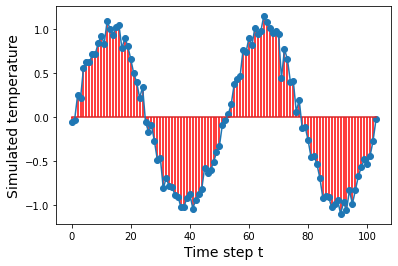

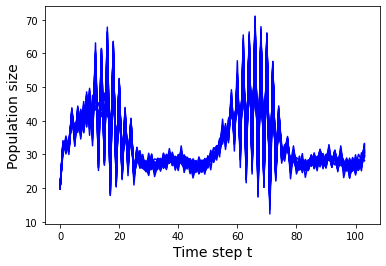

In [46]:
# create simulator object
sims = simulations.Simulator()
# Set hyperparameters. We'll simulate on a weekly resolution. Years is changed to weeks.
sims.hyper_parameters(simulated_years=2,
                           ensemble_size=30,
                           initial_size=20)
sims.simulation_parameters(regime="non-chaotic", behaviour="stochastic")
sims.environment('exogeneous', trend=False)
sims.model_type("single-species")
x = sims.simulate()


We create the perfect model setting by treating one trajectory from the simulated ensemble as observation.
We bootstrap this procedure to propagate uncertainty in initial conditions and thereby get a distribution of the SNR. Here, we use the squared-error-based SNR (Czanner et al. 2015, PNAS). This is calculcated based on the expected prediction error (HOWEVER: only defined on linear models which this is clearly not!)

$SNR = \frac{SS(y,\overline{y}) - SS(y,\hat{y})}{SS(y,\hat{y})}$

The signal is the reduction in prediction error by using the model instead of simply using the mean.

/Users/Marieke_Wesselkamp/PycharmProjects/Ricker/proficiency_metrics.py:77: RuntimeWarning: divide by zero encountered in double_scalars
  return signal/noise
/var/folders/s8/rp7pfvm507qcvckzx566r47c0000gp/T/ipykernel_58563/3108430522.py:27: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(bs_arr_modelworld), color="blue", alpha=0.3)
/var/folders/s8/rp7pfvm507qcvckzx566r47c0000gp/T/ipykernel_58563/3108430522.py:33: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.transpose(10*np.log10(bs_arr_modelworld)), color="blue", alpha = 0.3)


Text(0, 0.5, 'SS-SNR [decibel]')

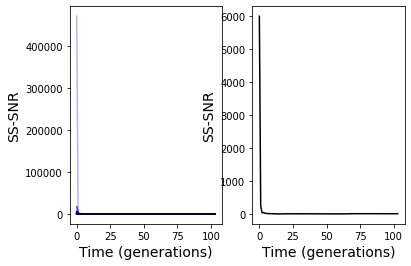

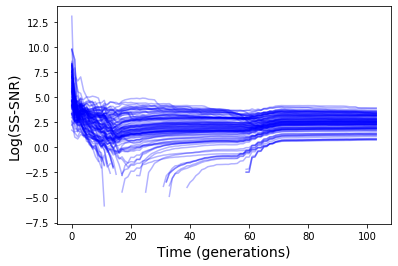

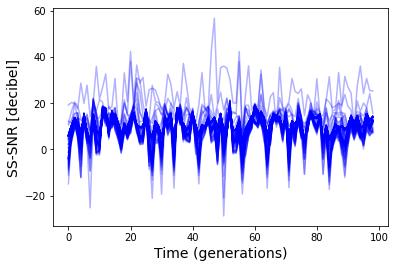

In [47]:
bs_samples = 100
bs_arr_modelworld = np.zeros((sims.hp['iterations'], bs_samples))
for j in range(bs_samples):
    obs_ind, pred_ind = np.random.randint(sims.hp['ensemble_size'], size=2)
    x_obs = x[obs_ind]
    x_pred = x[pred_ind]

    for i in range(sims.hp['iterations']):
        # skip the first step, we can't calculate a mean from only one datapoint.
        bs_arr_modelworld[i, j] = squared_error_SNR(x_obs[:i+2], x_pred[:i+2])

bs_arr_modelworld = bs_arr_modelworld[:,~np.isinf(bs_arr_modelworld).any(0)]

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(bs_arr_modelworld, color="blue", alpha=0.3)
ax1.plot(np.mean(bs_arr_modelworld, axis=1), color="black")
ax1.set_xlabel('Time (generations)', size=14)
ax1.set_ylabel('SS-SNR', size=14)
ax2.plot(np.mean(bs_arr_modelworld, axis=1), color="black")
ax2.set_xlabel('Time (generations)', size=14)
ax2.set_ylabel('SS-SNR', size=14)
#plt.plot(bs_arr_modelworld)

fig = plt.figure()
ax = fig.add_subplot()
#plt.plot(np.mean(np.log(bs_arr_modelworld), axis=1))
plt.plot(np.log(bs_arr_modelworld), color="blue", alpha=0.3)
ax.set_xlabel('Time (generations)', size=14)
ax.set_ylabel('Log(SS-SNR)', size=14)

fig = plt.figure()
ax = fig.add_subplot()
plt.plot(np.transpose(10*np.log10(bs_arr_modelworld)), color="blue", alpha = 0.3)
ax.set_xlabel('Time (generations)', size=14)
ax.set_ylabel('SS-SNR [decibel]', size=14)

Here, values for the SNR can get incredibly large at the beginning. This is due to the little uncertainty in trajectories: they are basically the same until time step 15.

Let's try it differently and simpler. We take the mean of the forecast distribution as signal and the dispersion as noise. To get a distribution, we evolve the ensemble of trajectories (Timothy delSole, 2004). As such, the signal is the expected value, $E[X]$ and the noise the variance, $Var[X] = E[X^2] - E[X]^2$.

With this, we calculate the raw SNR as:

$SNR = \frac{E[X]^2}{(E[X^2] - E[X]^2)^2}$


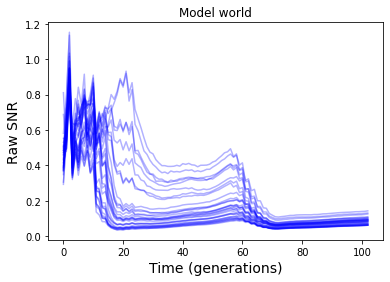

In [48]:
snr_list = []
for i in range(sims.hp['iterations']-1):
    snr_list.append(raw_SNR(x[:,:i+2]))


fig = plt.figure()
ax = fig.add_subplot()
plt.plot(np.array(snr_list), color="blue", alpha = 0.3)
ax.set_xlabel('Time (generations)', size=14)
ax.set_ylabel('Raw SNR', size=14)
ax.title.set_text('Model world')

## Imperfect Model Scenario: The data world

Now lets change world: From the Perfect Model Scenario, we move to the real world scenario. Doing so, we will use the real world model that is slightly more complex than the simple one. It contains an interaction with another species, that we will not consider (as if we weren't aware)


/Users/Marieke_Wesselkamp/PycharmProjects/Ricker/utils.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/Marieke_Wesselkamp/PycharmProjects/Ricker/models.py:157: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


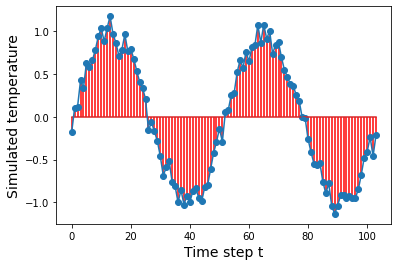

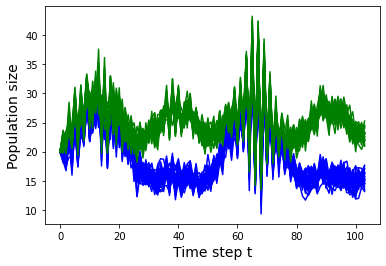

In [49]:
# create simulator object
sims = simulations.Simulator()
# Set hyperparameters. We'll simulate on a weekly resolution. Years is changed to weeks.
sims.hyper_parameters(simulated_years=2,
                           ensemble_size=30,
                           initial_size=(20, 20)) # here we have to give init for both populations
sims.simulation_parameters(regime="non-chaotic", behaviour="stochastic")
sims.environment('exogeneous', trend=False)
sims.model_type("multi-species")
x_real = sims.simulate()

15 27
14 17
16 8
3 26
24 16
11 0
20 0
6 12
12 12
1 7
8 8
27 9
17 17
0 0
8 23
12 12
6 4
15 26
23 20
8 0
15 2
24 28
27 21
8 0
11 12
16 11
25 12
4 14
28 11
5 11
16 9
28 15
12 0
29 27
20 21
22 20
9 3
13 12
20 10
18 28
4 14
11 11
10 8
28 3
19 19
12 19
23 16
0 28
13 24
1 26
6 24
21 13
13 14
3 15
28 21
13 24
5 25
5 26
9 9
12 7
14 20
24 17
20 19
14 0
8 3
20 17
27 21
28 24
7 21
24 21
12 12
28 0
0 12
3 9
25 6
4 16
13 21
16 10
20 29
7 12
4 15
5 17
18 20
17 7
29 9
9 11
17 0
8 15
3 26
15 23
24 25
8 17
2 10
9 21
2 28
17 23
19 25
26 16
17 1
15 23


/var/folders/s8/rp7pfvm507qcvckzx566r47c0000gp/T/ipykernel_58563/2546359646.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


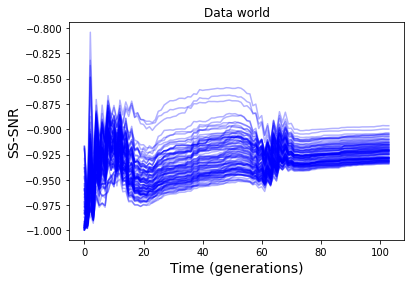

In [50]:
# We only use the data from one species, this is our real world data.
x_real = x_real[:,:,1]#.reshape(sims.hp['iterations'])

bs_samples = 100
bs_arr_dataworld = np.zeros((sims.hp['iterations'], bs_samples))
for j in range(bs_samples):
    obs_ind, pred_ind = np.random.randint(sims.hp['ensemble_size'], size=2)
    print(obs_ind, pred_ind)
    x_obs = x_real[obs_ind]
    x_pred = x[pred_ind]

    for i in range(sims.hp['iterations']):
        # skip the first step, we can't calculate a mean from only one datapoint.
        bs_arr_dataworld[i, j] = squared_error_SNR(x_obs[:i+2], x_pred[:i+2])

bs_arr_dataworld = bs_arr_dataworld[:,~np.isinf(bs_arr_dataworld).any(0)]
q1, q2 = np.quantile(bs_arr_dataworld, (0.1, 0.90), axis=1)
# Plot the SNR
fig = plt.figure()
ax = fig.add_subplot()
#ax.fill_between(np.arange(sims.hp['iterations']), q1, q2, color="lightgrey", alpha=0.3)
plt.plot(bs_arr_dataworld, color="blue", alpha = 0.3)
ax.set_xlabel('Time (generations)', size=14)
ax.set_ylabel('SS-SNR', size=14)
ax.title.set_text('Data world')
fig.show()

The task here is difficult through the chaotic behaviour of the model. In the perfect model scenario, what is it that we use as the variance of the noise?! If I use initial uncertainty, I will get a huge amplitude in the resulting SNR.

Now the predictability limit as the limit where the SNR falls below some threshold. Intuitively, this threshold is one: When Signal becomes weaker than the noise. What we see with this simple approach to setting a threshold is: Both times an EFH of zero: First, because the SNR never even comes close to zero, second because it is constantly negative.
Here it makes a big difference if we use the mean or the median!

In [51]:
SNR_model = np.mean(bs_arr_modelworld, axis=1)
SNR_data = np.mean(bs_arr_dataworld, axis=1)
threshold = 1
pred_skill_model = np.argmax(SNR_model < threshold)
pred_skill_data = np.argmax(SNR_data < threshold)
print('Forecast horizon in the perfect model scenario: ', pred_skill_model)
print('Forecast horizon in the data world scenario: ', pred_skill_data)

Forecast horizon in the perfect model scenario:  0
Forecast horizon in the data world scenario:  0
